### Can tidal forces and the Lidov-Kozai mechanism cause a system of exomoons to align in the same orbital plane?

This script creates a system of the Sun + Jupiter + the Galilean moons, and runs a gravity code on them to investigate the moons change of eccentricity and inclination due to the Lidov-Koszai effect. 

The script is designed such that you can tell it which moons you'd like to include.

In [3]:
# Packages
import h5py
import time
import numpy as np
from amuse.lab import Particles
from amuse.couple import bridge
import matplotlib.pyplot as plt
from amuse.units.constants import G
from amuse.units import units, constants
from amuse.lab import Huayno, nbody_system
from amuse.community.ph4.interface import ph4
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

In [8]:
def system_with_moons(moons, eccentricities, inclinations, kozai=True, *args):
    
    ''' Function to create a particle system of the Galileann moon(s) with Jupiter and the Sun.
        
    @Input: 
        list of Galileann Moon names in string format (any combination of: io, europa, ganymede, callisto), 
        list of eccentricities, list of inclinations (dimensionless).
               
    @Returns: 
        Particle system of the given moon set with the Sun and Jupiter.
        
    @Example: 
        system = make_moon_system(moons=['io', 'europa'], eccentricities=[0.4, 0.6], inclinations=[50, 60]) ''';
    
    
    # Assigning our variables
    x = zip(eccentricities, inclinations)
    y = list(x)
    z = {}
    for i in range(len(moons)):
        z[moons[i]] = y[i]   
    
    
    # Initialising Sun and Jupiter
    Msun = 1.0|units.MSun
    Mjup = 1.0|units.MJupiter
    rSun = 696340|units.km
    rJup = 69911|units.km
    a_jup = 5.2|units.au
    e_jup = 0.0
    
    system = new_binary_from_orbital_elements(Msun, Mjup, a_jup, e_jup, G=constants.G)
    system[0].name = 'sun'
    system[1].name = 'jupiter'
    jupiter = system[system.name=='jupiter']
    jupiter.semimajor_axis = a_jup
    jupiter.radius = rJup
    sun = system[system.name=='sun']
    sun.radius = rSun
    
    if kozai != True:
        system.remove_particle(system[0]) #removing the Sun
        system.move_to_center()
    
    
    # Function to automate addition of particles
    def add_particle(particle, a, e, inc, m, r):
        
        binary = new_binary_from_orbital_elements(jupiter.mass, m, a, eccentricity=e, inclination=inc, G=constants.G)
         
        system.add_particle(binary[1].as_set()) 
        system[-1].name = particle
        moon = system[system.name==particle] 
        
        moon.semimajor_axis = a
        moon.eccentricity = e
        moon.inclination = inc
        moon.radius = r
        moon.position = binary[1].position + jupiter.position
        moon.velocity = binary[1].velocity + jupiter.velocity
        
        system.move_to_center()
    
    
    # Add moons based on input
    if 'io' in moons:
        a = 421800|units.km
        e = z['io'][0]
        inc = z['io'][1]|units.deg
        m = 8.93E22|units.kg
        r = 1821.6|units.km
        add_particle('io', a, e, inc, m, r) 
    
    if 'europa' in moons:
        a = 671100|units.km
        e = z['europa'][0]
        inc = z['europa'][1]|units.deg
        m = 4.80E22|units.kg
        r = 1560.8|units.km
        add_particle('europa', a, e, inc, m, r)  

    if 'ganymede' in moons:
        a = 1070400|units.km
        e = z['ganymede'][0]
        inc = z['ganymede'][1]|units.deg
        m = 1.48E23|units.kg
        r = 2634.1|units.km
        add_particle('ganymede', a, e, inc, m, r)   
        
    if 'callisto' in moons:
        a = 1882700|units.km
        e = z['callisto'][0]
        inc = z['callisto'][1]|units.deg
        m = 1.08E23|units.kg
        r = 2410.3|units.km
        add_particle('callisto', a, e, inc, m, r)  
        
    print('Particle system created for: '+ str(system.name))
    return system

In [10]:
# Testing
moons = ['io', 'europa', 'ganymede', 'callisto']
eccentricities = [0.3, 0.4, 0.5, 0.6]
inclinations = [40, 50, 60, 70]

system = system_with_moons(moons, eccentricities, inclinations)

Particle system created for: ['sun' 'jupiter' 'io' 'europa' 'ganymede' 'callisto']


In [12]:
# Tidal forces
class TidalForce():
    def __init__(self, alpha=0.1, kdt=2e-2):
        self.alpha=alpha
        self.kdt = kdt
        
    
    def add_particles(self, particle_set):
        self.particles = particle_set
    
    
    def tidal_acceleration(self, k, alpha):
        R = (1|units.RJupiter).value_in(units.m) 
        M = (1|units.MJupiter).value_in(units.kg)
        G = constants.G.value_in( (units.m)**3 / (units.kg * units.s**2) )
        r = np.sqrt(np.sum(np.square(self.particles.position.value_in(units.m) - \
                                     self.particles[1].position.value_in(units.m)), axis=1))
        
        abs_vel = np.sqrt(np.sum(np.square(self.particles.velocity.value_in(units.m*units.s**-1)), axis=1))
        abs_acc = np.zeros(len(self.particles))
        mask = np.arange(len(self.particles)) != 1
        abs_acc[mask] = -9*k*G*self.particles.mass[mask].value_in(units.kg)*(R**5)*\
        np.sin(2*alpha)/(4*r[mask]**7)
        abs_acc = abs_acc * 1|units.m*units.s**-2
                
        ax = abs_acc*(self.particles.vx.value_in(units.m*units.s**-1)/abs_vel)
        ay = abs_acc*(self.particles.vy.value_in(units.m*units.s**-1)/abs_vel)
        az = abs_acc*(self.particles.vz.value_in(units.m*units.s**-1)/abs_vel)
        
        return ax, ay, az
    
    
    def get_gravity_at_point(self, eps, x, y, z):
        return self.comp_tidal_acceleration(kdt=self.kdt) #k from literature, alpha guess
    
    def comp_tidal_acceleration(self, kdt):
        #the number of satellites is needed to reshape the arrays such that all arrays can be contracted
        #in the correct way (eg multiplication of arrays of vectors, with arrays)
        num_sat = len(self.particles)-1
        mask = self.particles.name != 'jupiter'
        
        #initializing some constants
        M = (1|units.MJupiter).value_in(units.kg)
        G = constants.G.value_in( (units.m)**3 / (units.kg * units.s**2) )
        c = constants.c.value_in( units.m/units.s)
        
        #obtaining some attributes of the sattelites
        m = (self.particles.mass.value_in(units.kg)[mask]).reshape((num_sat,1))
        R_sat = (self.particles.radius.value_in(units.m)[mask]).reshape((num_sat,1))
        
        #calculating the relative positions/distances and velocities 
        r_vec = self.particles[mask].position.value_in(units.m) - self.particles[~mask].position.value_in(units.m)
        r = np.sqrt(np.sum(np.square(r_vec),axis=1)).reshape((num_sat,1)) #distance between moons and jupiter
        
        v_vec = self.particles[mask].velocity.value_in(units.m/units.s) - \
                self.particles[~mask].velocity.value_in(units.m/units.s)
        v = np.sqrt(np.sum(np.square(v_vec),axis=1)).reshape((num_sat,1))
        
        omega = np.cross(r_vec,v_vec)/r**2
        
        #PAPER: Tidal decay and orbital circularization in closein twoplanet systems
        
        #calculating the tidal force
        f = -3*kdt*G*(M**2)*(R_sat**5)/(r**10)*( 2*r_vec*(np.sum(r_vec*v_vec, axis=1).reshape((num_sat,1))) +\
                                                 (r**2)*( np.cross(r_vec,omega) + v_vec ))
        
        #calculating the general relativity correction
        f_rel = G*m*M/(c**2 * (r)**3)*( (4*G*M/r - v**2)*r_vec + \
                        4*(np.sum(r_vec*v_vec,axis=1).reshape(num_sat,1))*v_vec)
        
        #calculating the acceleration due to tidal effects
        a = (M + m)/(M*m)*(f+f_rel)
        
        ax = np.zeros(num_sat+1)
        ay = np.zeros(num_sat+1)
        az = np.zeros(num_sat+1)
        
        ax[mask] = a[:,0]
        ay[mask] = a[:,1]
        az[mask] = a[:,2]
        
        ax = ax * 1 | units.m/(units.s**2)
        ay = ay * 1 | units.m/(units.s**2)
        az = az * 1 | units.m/(units.s**2)
        
        return ax, ay, az
    

def energy_dissipation(system, k=0.565, alpha=0.1):
    """ Calculates the total energy dissipation due to the tidal force for a particle system. The 
        second particle in the particle set is the particle that exerts the tidal force. """

    # Defining some constants
    R = (1|units.RJupiter).value_in(units.m) #radius of Jupiter
    M = (1|units.MJupiter).value_in(units.kg)
    G = constants.G.value_in( (units.m)**3 / (units.kg * units.s**2) )
    
    # To exclude the force of Jupiter on itself
    mask = system.name != 'jupiter'
    
    # Getting some parameters/values from the particle set
    m = system.mass.value_in(units.kg)
    r = np.sqrt(np.sum(np.square(system.position.value_in(units.m) - \
                                 system[~mask].position.value_in(units.m)), axis=1))
    
    # The energy dissipation
    dE_dt = -9*k*G**(3/2)*M**(1/2)*m[mask]**2*R**5*np.sin(2*alpha)/(2*r[mask]**(15/2))
   
    return np.sum(dE_dt) * 1|units.J/units.s


def get_energies(system, timestep, k=0.565, alpha=0.1):
    """ Calculates the total energy of the system, along with the energy dissipation. """

    # Getting the kinetic and potential energy from the particle system
    E_kin = system.kinetic_energy()
    E_pot = system.potential_energy()
    E_tot = E_kin + E_pot
    
    # Getting the energy dissipation
    dE_dt = energy_dissipation(system)

    # Getting the total dissipated energy in the following timestep
    dE = dE_dt*timestep
    
    return E_tot, dE

In [19]:
def integrate_system(moons, eccentricities, inclinations, kdt, dt, end_time, kozai=True):
    
    ''' Function to integrate the system over time using a gravity code.

    @Input: 
        list of Galileann Moon names in string format (any combination (but in order!) of: io, 
        europa, ganymede, callisto), eccentricities, inclinations, kdt, integration time step and
        end time.

    @Returns: 
        list of evolved eccentrities, inclinations, semimajor-axis values, total eneries, 
        energy dissipation, and  the time range at time step intervals.

    @Example: 
        ecc, inc, sma, Etot, Ediss, time_range = integrate_system(moons=['io'], 
        eccentricities=[0.3], inclinations=[50], 10|units.yr, 1000|units.yr) ''';
    
    
    # Checking how long code takes to run
    start_time = time.time()
    
    # Getting system
    system = system_with_moons(moons, eccentricities, inclinations, kozai=kozai)
    
    # Converting Nbody
    converter = nbody_system.nbody_to_si(system.mass.sum(), system[1].position.length())
    
    # Gravity code
    gravity = Huayno(converter)
    gravity.particles.add_particles(system)
    
    # Eccentricities
    e_io = []
    e_eu = []
    e_ga = []
    e_ca = []
    
    # Inclinations
    i_io = [] | units.deg
    i_eu = [] | units.deg
    i_ga = [] | units.deg
    i_ca = [] | units.deg
    
    #Semimajor axes 
    a_io = [] | units.m
    a_eu = [] | units.m
    a_ga = [] | units.m
    a_ca = [] | units.m

    # Tidal force
    tf = TidalForce(kdt=kdt)
    tf.add_particles(system)
    
    # Bridge for tidal effects
    our_bridge = bridge.Bridge(use_threading=False)    
    our_bridge.add_system(gravity, (tf,))
    
    # Channels
    channel_grav = gravity.particles.new_channel_to(system)
    channel_tf = tf.particles.new_channel_to(system)
    
    E_tot = []
    E_dissipation = []
    
    # Running gravity code
    dt = dt|units.yr
    end_time = end_time|units.yr
    model_time = np.arange(0, end_time.value_in(units.yr), dt.value_in(units.yr)) | units.yr
    
    for tstep in model_time:
        
        if 'io' in moons:
            orbit_io = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='io')],
                                                        G=constants.G)
            
        if 'europa' in moons:
            orbit_eu = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='europa')],
                                                        G=constants.G)
            
        if 'ganymede' in moons:
            orbit_ga = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='ganymede')],
                                                        G=constants.G)
            
        if 'callisto' in moons:
            orbit_ca = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='callisto')],
                                                        G=constants.G)
        
        
        our_bridge.evolve_model(tstep)
        channel_grav.copy()
        channel_tf.copy()
        
        E, E_diss = get_energies(system,dt)
        E_tot.append(E.value_in(units.J))
        E_dissipation.append(E_diss.value_in(units.J))
        
        if 'io' in moons:
            a_io.append(orbit_io[2])
            e_io.append(orbit_io[3])
            i_io.append(orbit_io[5])
            
        
        if 'europa' in moons:
            a_eu.append(orbit_eu[2])
            e_eu.append(orbit_eu[3])
            i_eu.append(orbit_eu[5])
            
        
        if 'ganymede' in moons:
            a_ga.append(orbit_ga[2])
            e_ga.append(orbit_ga[3])
            i_ga.append(orbit_ga[5])
            
        
        if 'callisto' in moons:
            a_ca.append(orbit_ca[2])
            e_ca.append(orbit_ca[3])
            i_ca.append(orbit_ca[5])
        
        
    our_bridge.stop()
    
    
    ecc = []
    inc = [] | units.deg
    sma = [] | units.m
    
    if 'io' in moons:
        ecc.append(e_io)
        inc.append(i_io)
        sma.append(a_io)
        
    if 'europa' in moons:
        ecc.append(e_eu)
        inc.append(i_eu)
        sma.append(a_eu)
        
    if 'ganymede' in moons:
        ecc.append(e_ga)
        inc.append(i_ga)
        sma.append(a_ga)
        
    if 'callisto' in moons:
        ecc.append(e_ca)
        inc.append(i_ca)
        sma.append(a_ca)
        
    
    # Printing runtime
    print('Runtime: %s seconds' % (time.time() - start_time))
    
    
    return ecc, inc, model_time, sma, E_tot, E_dissipation

In [ ]:
# Running code
moons = ['io', 'europa', 'ganymede', 'callisto']
eccentricities = [0.3, 0.4, 0.5, 0.6]
inclinations = [40, 50, 60, 70]

dt = 100
end_time = 10000
kdt = 2e-2

ecc, inc, time_range, sma, Etot, Ediss = integrate_system(moons, eccentricities, inclinations, kdt, dt, end_time)

In [22]:
# Running code
moons = ['europa']
eccentricities = [0.2]
inclinations = [0]

dt = 10
end_time = 100
kdt = 2e-2

ecc, inc, time_range, sma, Etot, Ediss = integrate_system(moons, eccentricities, inclinations, kdt, dt, end_time)

Particle system created for: ['sun' 'jupiter' 'europa']
Runtime: 3.187260389328003 seconds


In [7]:
def plot_tracks(moons, ecc, inc, sma, time_range, savefig=False, figname='evolved_tracks'):
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[20, 15], tight_layout=True)
    colours = ['r', 'g', 'b', 'm']

    for i in range(len(moons)):
        ax1.plot(time_range.value_in(units.yr), inc[i].value_in(units.deg), color=colours[i], label=moons[i])   
    ax1.set_ylabel('Inclination [deg]')
    ax1.legend()

    for i in range(len(moons)):
        ax2.plot(time_range.value_in(units.yr), np.array(ecc[i]), color=colours[i], label=moons[i])   
    ax2.set_ylabel('Eccentricity')
    ax2.set_xlabel('Time [years]')
    ax2.legend()
    
    for i in range(len(moons)):
        ax3.plot(time_range.value_in(units.yr), sma[i].value_in(units.m), color=colours[i], label=moons[i])   
    ax3.set_ylabel('Semimajor Axis')
    ax3.set_xlabel('Time [years]')
    ax3.legend()    
    
    plt.suptitle('Huayno Code (dt={}yr)'.format((time_range[2]-time_range[1]).value_in(units.yr)))
    plt.subplots_adjust(top=0.94)
    if savefig:
        plt.savefig(figname+'.png', facecolor='w', bbox_inches='tight')
    plt.show()

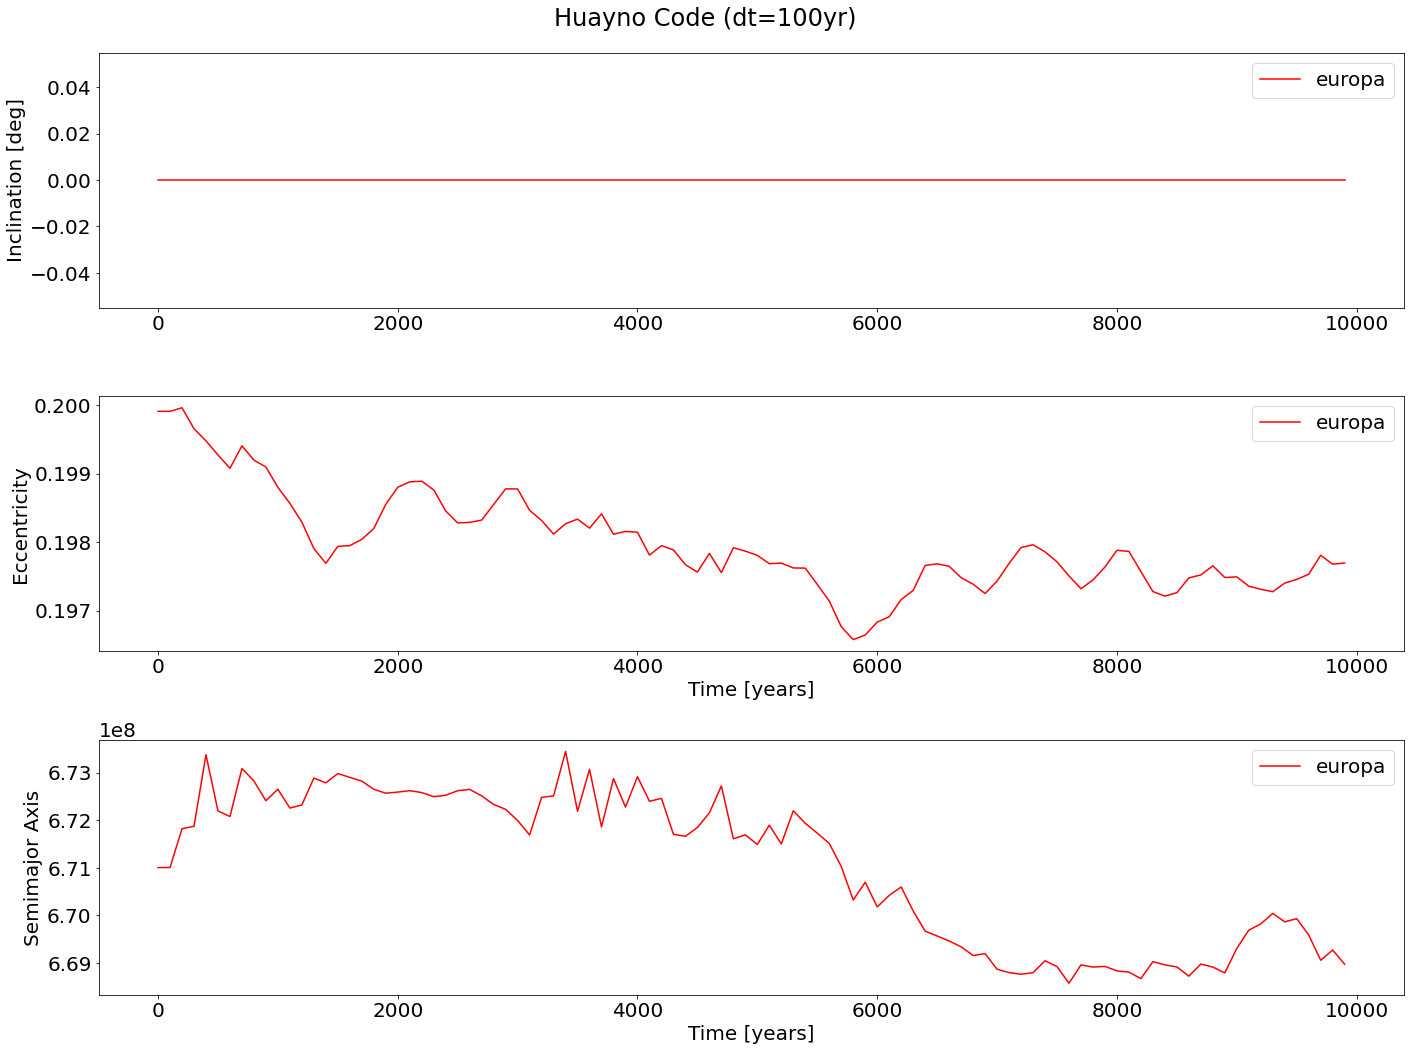

In [8]:
plot_tracks(moons, ecc, inc, sma, time_range)

In [ ]:
def check_lz(moons, ecc, inc):
    
    ''' The Kozai-constant Lz should be (approximately) conserved. This function will check this by computing Lz.
    
    @Input: 
        list of moons, eccentricites and inclinations obtained from the integrate_system() function
    
    @Returns: 
        array of Lz's for each instance for each moon, and plots!
    
    @Example: 
        lz = check_lz(moons, ecc, inc) '''
    
    
    # Lz=sqrt(1-e**2)*cos(i)
    lz = np.zeros_like(ecc)
    for i in range(len(lz[0])):
        for j in range(len(lz[0:])):
            x = np.sqrt(1 - ecc[j][i]**2) * np.cos(inc[j][i].value_in(units.rad))
            lz[j][i] = x
    
    # Standard deviations
    sdev = []
    for i in range(len(lz[0:])):
        y = np.std(lz[i:])
        sdev.append(y)
    
    # Plotting
    colours = ['r', 'g', 'b', 'm']     
    plt.rcParams.update({'font.size': 20})
    
    # Sizes of subplots are annoying
    if len(lz[0:]) < 4:
        figsize=[10,8]
    else:
        figsize=[10,12]
    
    fig, ax = plt.subplots(len(lz[0:]), 1, figsize=figsize, constrained_layout=True)    
    
    for i, ax in enumerate(fig.axes):
        ax.plot(time_range.value_in(units.yr), lz[i], '-o', color=colours[i], lw=1, label=moons[i])
        ax.plot([], [], ' ', label='std = '+str(round(sdev[i],3)))
        ax.legend(fontsize=16) 
        
    plt.suptitle('Lz vs Time')
    #plt.subplots_adjust(top=0.94)
    plt.show()
                           
    return lz

In [ ]:
lz = check_lz(moons, ecc, inc)

In [ ]:
def plot_energy_evolution(moons, Etot, time_range):
    
    # Plotting   
    plt.rcParams.update({'font.size': 20})
    
    plt.figure(figsize=[8,6], tight_layout=True)     
    plt.plot(time_range.value_in(units.yr), Etot,'-o', lw=1)
    plt.title('Total Energy of System', pad=30)
    plt.xlabel('Time [yr]')
    plt.ylabel('Energy [J]')
    plt.show()

In [ ]:
plot_energy_evolution(moons, Etot, time_range)

In [ ]:
# Conditions for Lidov-Kozai to take effect: ~ 40-140 deg inclinations
# We will test 30-150 deg inclinations in steps of 10 deg (13 values)
# We will test eccentricities in steps of 0.08 starting from 0.0 (13 values)
# 5000 years with dt=100 gives runtime ~ 90 seconds

def param_space(moons):
    
    start_time = time.time()
    filename  = 'results.hdf5'
    results = h5py.File(filename, 'w')
    
    dt = 100|units.yr
    end_time = 5000|units.yr
    
    all_inc = np.arange(30, 160, 10)
    all_ecc = np.arange(0.0, 1.0, 0.08)
    
    for i in range(len(all_ecc)):
        print('inc='+str(all_inc[i]))
        g1 = results.create_group('inc='+str(all_inc[i]))
        for j in range(len(all_ecc)):
            ecc, inc, time_range, sma, Etot, diss = integrate_system(moons, [all_ecc[j]], [all_inc[i]], dt, end_time)
            g2 = g1.create_group('ecc='+str(all_ecc[j]))
            g2['inc'] = inc[0].value_in(units.deg)
            g2['ecc'] = ecc[0]
            g2['sma'] = sma[0].value_in(units.m)
            g2['Etot'] = Etot
            g2['diss'] = diss
        print('')
        
    results.close()
    print('\nTotal runtime: %s hours' % ((time.time() - start_time)/3600))

In [ ]:
# Don't run this
# moons = ['europa']
# param_space(moons)

In [7]:
def plot_params():
    start_time = time.time()

    model_time = np.arange(0, 5000, 100)
    res = h5py.File('results.hdf5')

    for j in range(13):
        fig, axis = plt.subplots(6, 2, figsize=(20, 15), tight_layout=True)
        allaxes = np.array(fig.get_axes())
        axes = allaxes.ravel()
        
        for i, ax in enumerate(axes):
            x = list(res.keys())
            y = list(res[x[j]].keys())

            ecc = res[x[j]][y[i]]['ecc'][:]
            inc = res[x[j]][y[i]]['inc'][:]

            ax.plot(model_time, ecc)
            ax.set_title(y[i], fontsize=14)
            ax.set_xlabel('t [yr]', fontsize=14)
            ax.set_ylabel('e', fontsize=14, rotation=1, labelpad=8)
            ax1 = ax.twinx()
            ax1.plot(model_time, inc, c='r', ls='--')
            ax1.set_ylabel('i', fontsize=14, rotation=1, labelpad=8)

        plt.suptitle(x[j] + ' [deg]', fontsize=20)
        plt.savefig('{}.png'.format(x[j]), facecolor='w', bbox_inches='tight')

    res.close()
    print('Runtime: %s seconds' % (time.time() - start_time))

In [ ]:
def plot_params_sma():
    start_time = time.time()

    model_time = np.arange(0, 5000, 100)
    res = h5py.File('results.hdf5')

    for j in range(13):
        fig, axis = plt.subplots(6, 2, figsize=(20, 15), tight_layout=True)
        allaxes = np.array(fig.get_axes())
        axes = allaxes.ravel()
        
        for i, ax in enumerate(axes):
            x = list(res.keys())
            y = list(res[x[j]].keys())
            sma = res[x[j]][y[i]]['sma'][:]

            ax.plot(model_time, sma)
            ax.set_title(y[i], fontsize=14)
            ax.set_xlabel('t [yr]', fontsize=14)
            ax.set_ylabel('a', fontsize=14, rotation=1, labelpad=8)

        plt.suptitle(x[j] + ' [deg]', fontsize=20)
        plt.savefig('{}_sma.png'.format(x[j]), facecolor='w', bbox_inches='tight')

    res.close()
    print('Runtime: %s seconds' % (time.time() - start_time))